In [31]:
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from sklearn.metrics import accuracy_score, classification_report
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("Setup complete")

Setup complete


In [32]:
ROOT_DIR = "dataset/fruit360"
TEST_DIR = os.path.join(ROOT_DIR, "Test")

class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]

transform_base = T.Compose([
    T.Resize((100, 100)),
    T.ToTensor(),
])

test_dataset = Fruit360FolderDataset(TEST_DIR, transform=transform_base, variety=False)

print(f"Test dataset loaded: {len(test_dataset)} images")
print(f"Number of classes: {len(test_dataset.label_to_idx)}")

Test: 43442 images, 79 classes
Test dataset loaded: 43442 images
Number of classes: 79


In [33]:
MODEL_DIR = "saved_models"

model_configs = {
    "8x8": {
        "size": 8,
        "scaler_path": os.path.join(MODEL_DIR, "scaler_8x8.joblib"),
        "pca_path": os.path.join(MODEL_DIR, "pca_8x8.joblib"),
        "svm_path": os.path.join(MODEL_DIR, "svm_8x8.joblib"),
    },
    "16x16": {
        "size": 16,
        "scaler_path": os.path.join(MODEL_DIR, "scaler_16x16.joblib"),
        "pca_path": os.path.join(MODEL_DIR, "pca_16x16.joblib"),
        "svm_path": os.path.join(MODEL_DIR, "svm_16x16.joblib"),
    },
    "32x32": {
        "size": 32,
        "scaler_path": os.path.join(MODEL_DIR, "scaler_32x32.joblib"),
        "pca_path": os.path.join(MODEL_DIR, "pca_32x32.joblib"),
        "svm_path": os.path.join(MODEL_DIR, "svm_32x32.joblib"),
    },
}

models = {}

for model_name, config in model_configs.items():
    print(f"Loading {model_name}...")
    models[model_name] = {
        "size": config["size"],
        "scaler": joblib.load(config["scaler_path"]),
        "pca": joblib.load(config["pca_path"]),
        "svm": joblib.load(config["svm_path"]),
    }
    print(f"  ✓ {model_name}: {models[model_name]['pca'].n_components_} PCA components")

print("\nAll models loaded successfully")

Loading 8x8...
  ✓ 8x8: 55 PCA components
Loading 16x16...
  ✓ 16x16: 158 PCA components
Loading 32x32...
  ✓ 32x32: 66 PCA components

All models loaded successfully


In [34]:
import math

def clamp01(x):
    return torch.clamp(x, 0.0, 1.0)

degradations_camera = {
    "clean": lambda x: x,
    "grayscale": lambda x: x.mean(dim=0, keepdim=True).repeat(3, 1, 1),
    "blur_medium": T.GaussianBlur(kernel_size=5, sigma=1.0),
    "noise_medium": lambda x: clamp01(x + torch.randn_like(x) * 0.07),
    "dark": lambda x: clamp01(x * 0.4),
    "overexposed": lambda x: clamp01(x * 1.8),
}

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area * r))
        patch_w = int(math.sqrt(patch_area / r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        
        patch = out[:, top:bottom, left:right]
        blended = alpha * patch + (1 - alpha) * color
        out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

def add_occlusion_patch(x, area_ratio=0.15, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area * r))
    patch_w = int(math.sqrt(patch_area / r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    
    patch = out[:, top:bottom, left:right]
    blended = alpha * patch + (1 - alpha) * color
    out[:, top:bottom, left:right] = blended
    
    return clamp01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

degradations_fruit = {
    "dirty": lambda x: add_color_patches(x, num_patches=3, color=color_dirt,
                                         alpha_range=(0.5, 0.75), size_range=(0.05, 0.12)),
    "bruised": lambda x: add_color_patches(x, num_patches=2, color=color_bruise,
                                           alpha_range=(0.4, 0.7), size_range=(0.04, 0.10)),
    "occlusion": lambda x: add_occlusion_patch(x, area_ratio=0.15, alpha=0.5),
}

degradations_to_test = {**degradations_camera, **degradations_fruit}

print("Degradations defined:")
for k in degradations_to_test.keys():
    print(f"  - {k}")

Degradations defined:
  - clean
  - grayscale
  - blur_medium
  - noise_medium
  - dark
  - overexposed
  - dirty
  - bruised
  - occlusion


In [35]:
def evaluate_model_on_degradation(model_name, model_obj, test_dataset, degradation_fn, degradation_name):
    
    size = model_obj["size"]
    scaler = model_obj["scaler"]
    pca = model_obj["pca"]
    svm = model_obj["svm"]
    
    y_true = []
    y_pred = []
    
    start_time = time.time()
    
    for img_100, label in test_dataset:
        img_resized = TF.resize(img_100, (size, size))
        
        img_degraded = degradation_fn(img_resized)
        
        img_flat = img_degraded.view(-1).numpy()
        
        img_scaled = scaler.transform([img_flat])
        img_pca = pca.transform(img_scaled)
        pred = svm.predict(img_pca)[0]
        
        y_true.append(label)
        y_pred.append(pred)
    
    elapsed = time.time() - start_time
    
    accuracy = accuracy_score(y_true, y_pred)
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    macro_avg = report["macro avg"]
    weighted_avg = report["weighted avg"]
    
    result_global = {
        "model_name": model_name,
        "model_size": size,
        "degradation": degradation_name,
        "accuracy": accuracy,
        "macro_precision": macro_avg["precision"],
        "macro_recall": macro_avg["recall"],
        "macro_f1": macro_avg["f1-score"],
        "weighted_precision": weighted_avg["precision"],
        "weighted_recall": weighted_avg["recall"],
        "weighted_f1": weighted_avg["f1-score"],
        "test_time_sec": elapsed,
    }
    
    results_per_class = []
    for class_idx, class_label in test_dataset.idx_to_label.items():
        class_str = str(class_idx)
        if class_str in report:
            cls_metrics = report[class_str]
            results_per_class.append({
                "model_name": model_name,
                "model_size": size,
                "degradation": degradation_name,
                "class_label": class_label,
                "precision": cls_metrics["precision"],
                "recall": cls_metrics["recall"],
                "f1": cls_metrics["f1-score"],
                "support": cls_metrics["support"],
            })
    
    return result_global, results_per_class

print("Evaluation function defined")

Evaluation function defined


In [36]:
results_global = []
results_per_class = []

print("Results storage initialized")

Results storage initialized


In [ ]:
print("="*60)
print("Testing: CLEAN (baseline)")
print("="*60)

degradation_name = "clean"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nClean baseline complete")

Testing: CLEAN (baseline)

  Testing 8x8...
    ✓ Accuracy: 0.9794 | Time: 299.33s

  Testing 16x16...
    ✓ Accuracy: 0.9815 | Time: 344.24s

  Testing 32x32...
    ✓ Accuracy: 0.9742 | Time: 343.20s

  Testing 64x64...


KeyError: '64x64'

In [38]:
print("="*60)
print("Testing: GRAYSCALE")
print("="*60)

degradation_name = "grayscale"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nGrayscale test complete")

Testing: GRAYSCALE

  Testing 8x8...
    ✓ Accuracy: 0.4022 | Time: 299.61s

  Testing 16x16...
    ✓ Accuracy: 0.3821 | Time: 348.65s

  Testing 32x32...
    ✓ Accuracy: 0.4744 | Time: 351.64s

Grayscale test complete


In [39]:
print("="*60)
print("Testing: BLUR_MEDIUM")
print("="*60)

degradation_name = "blur_medium"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nBlur test complete")

Testing: BLUR_MEDIUM

  Testing 8x8...
    ✓ Accuracy: 0.0663 | Time: 309.30s

  Testing 16x16...
    ✓ Accuracy: 0.4525 | Time: 357.23s

  Testing 32x32...
    ✓ Accuracy: 0.8810 | Time: 353.60s

Blur test complete


In [40]:
print("="*60)
print("Testing: NOISE_MEDIUM")
print("="*60)

degradation_name = "noise_medium"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nNoise test complete")

Testing: NOISE_MEDIUM

  Testing 8x8...
    ✓ Accuracy: 0.8129 | Time: 319.48s

  Testing 16x16...
    ✓ Accuracy: 0.2746 | Time: 363.32s

  Testing 32x32...
    ✓ Accuracy: 0.0946 | Time: 360.70s

Noise test complete


In [41]:
print("="*60)
print("Testing: DARK & OVEREXPOSED")
print("="*60)

for degradation_name in ["dark", "overexposed"]:
    print(f"\n--- {degradation_name.upper()} ---")
    degradation_fn = degradations_to_test[degradation_name]
    
    for model_name in ["8x8", "16x16", "32x32"]:
        print(f"  Testing {model_name}...")
        result_global, result_per_class = evaluate_model_on_degradation(
            model_name=model_name,
            model_obj=models[model_name],
            test_dataset=test_dataset,
            degradation_fn=degradation_fn,
            degradation_name=degradation_name,
        )
        results_global.append(result_global)
        results_per_class.extend(result_per_class)
        
        print(f"    ✓ Accuracy: {result_global['accuracy']:.4f}")

print("\nLighting tests complete")

Testing: DARK & OVEREXPOSED

--- DARK ---
  Testing 8x8...
    ✓ Accuracy: 0.0425
  Testing 16x16...
    ✓ Accuracy: 0.0148
  Testing 32x32...
    ✓ Accuracy: 0.0941

--- OVEREXPOSED ---
  Testing 8x8...
    ✓ Accuracy: 0.2144
  Testing 16x16...
    ✓ Accuracy: 0.3073
  Testing 32x32...
    ✓ Accuracy: 0.2960

Lighting tests complete


In [44]:
print("="*60)
print("Testing: DIRTY")
print("="*60)

degradation_name = "dirty"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nDirty test complete")

Testing: DIRTY

  Testing 8x8...
    ✓ Accuracy: 0.7383 | Time: 318.65s

  Testing 16x16...
    ✓ Accuracy: 0.7324 | Time: 410.16s

  Testing 32x32...
    ✓ Accuracy: 0.7139 | Time: 423.17s

Dirty test complete


In [45]:
print("="*60)
print("Testing: BRUISED")
print("="*60)

degradation_name = "bruised"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nBruised test complete")

Testing: BRUISED

  Testing 8x8...
    ✓ Accuracy: 0.7940 | Time: 349.58s

  Testing 16x16...
    ✓ Accuracy: 0.7903 | Time: 361.64s

  Testing 32x32...
    ✓ Accuracy: 0.7798 | Time: 348.75s

Bruised test complete


In [46]:
print("="*60)
print("Testing: OCCLUSION")
print("="*60)

degradation_name = "occlusion"
degradation_fn = degradations_to_test[degradation_name]

for model_name in ["8x8", "16x16", "32x32"]:
    print(f"\n  Testing {model_name}...")
    result_global, result_per_class = evaluate_model_on_degradation(
        model_name=model_name,
        model_obj=models[model_name],
        test_dataset=test_dataset,
        degradation_fn=degradation_fn,
        degradation_name=degradation_name,
    )
    results_global.append(result_global)
    results_per_class.extend(result_per_class)
    
    print(f"    ✓ Accuracy: {result_global['accuracy']:.4f} | Time: {result_global['test_time_sec']:.2f}s")

print("\nOcclusion test complete")

Testing: OCCLUSION

  Testing 8x8...
    ✓ Accuracy: 0.8596 | Time: 309.61s

  Testing 16x16...
    ✓ Accuracy: 0.8413 | Time: 358.46s

  Testing 32x32...
    ✓ Accuracy: 0.8273 | Time: 331.91s

Occlusion test complete


In [47]:
print("="*60)
print("Converting results to DataFrames...")
print("="*60)

results_global_df = pd.DataFrame(results_global)
results_per_class_df = pd.DataFrame(results_per_class)

print(f"Global results: {len(results_global_df)} rows")
print(f"Per-class results: {len(results_per_class_df)} rows")

os.makedirs("results", exist_ok=True)
results_global_df.to_csv("results/robustness_global.csv", index=False)
results_per_class_df.to_csv("results/robustness_per_class.csv", index=False)

print("\n✓ Results saved:")
print("  - results/robustness_global.csv")
print("  - results/robustness_per_class.csv")

print("\nFirst few rows of global results:")
print(results_global_df.head(10))

Converting results to DataFrames...
Global results: 27 rows
Per-class results: 2133 rows

✓ Results saved:
  - results/robustness_global.csv
  - results/robustness_per_class.csv

First few rows of global results:
  model_name  model_size   degradation  accuracy  macro_precision  \
0        8x8           8         clean  0.979421         0.986356   
1      16x16          16         clean  0.981539         0.988891   
2      32x32          32         clean  0.974242         0.986499   
3        8x8           8     grayscale  0.402168         0.404306   
4      16x16          16     grayscale  0.382096         0.413359   
5      32x32          32     grayscale  0.474403         0.452023   
6        8x8           8   blur_medium  0.066295         0.070074   
7      16x16          16   blur_medium  0.452488         0.700500   
8      32x32          32   blur_medium  0.881037         0.960354   
9        8x8           8  noise_medium  0.812946         0.939599   

   macro_recall  macro_f1  

Generating bar plot: Accuracy per degradation


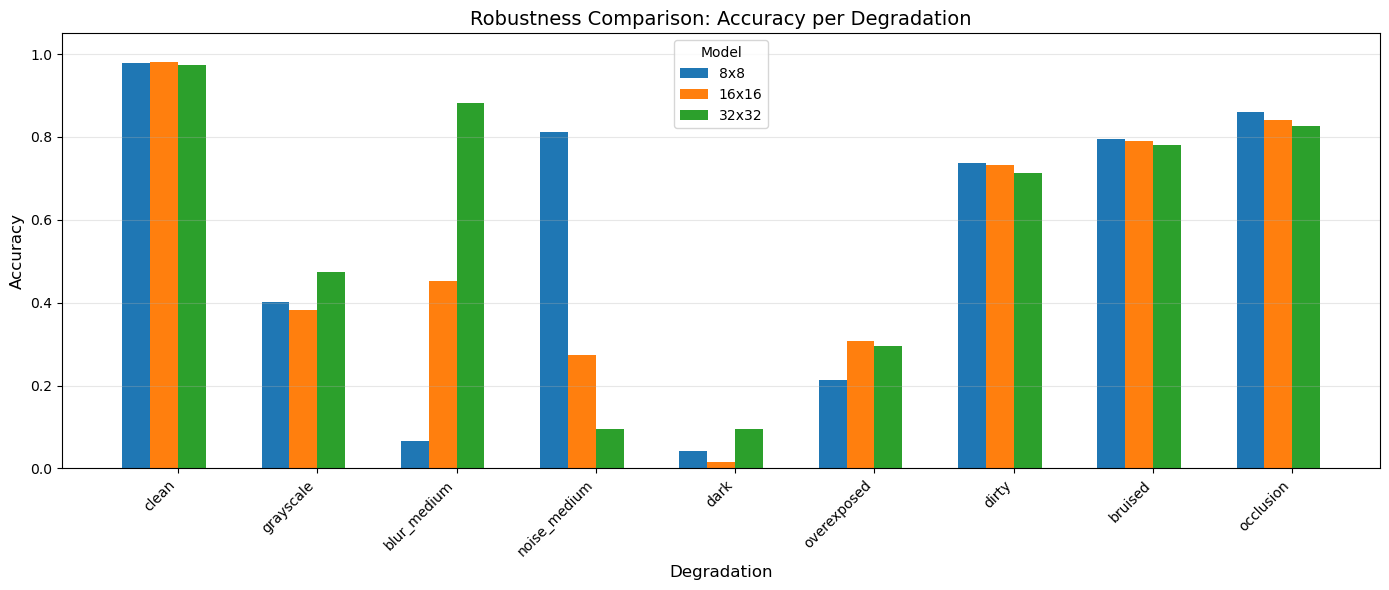

In [48]:
print("Generating bar plot: Accuracy per degradation")

degradation_order = ["clean", "grayscale", "blur_medium", "noise_medium", "dark", "overexposed", "dirty", "bruised", "occlusion"]

plot_data = results_global_df[results_global_df["degradation"].isin(degradation_order)].copy()
plot_data["degradation"] = pd.Categorical(plot_data["degradation"], categories=degradation_order, ordered=True)
plot_data = plot_data.sort_values("degradation")

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(degradation_order))
width = 0.2

models = ["8x8", "16x16", "32x32"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for i, model_name in enumerate(models):
    model_data = plot_data[plot_data["model_name"] == model_name]
    accuracies = [model_data[model_data["degradation"] == deg]["accuracy"].values[0] if len(model_data[model_data["degradation"] == deg]) > 0 else 0 for deg in degradation_order]
    
    ax.bar(x + i*width, accuracies, width, label=model_name, color=colors[i])

ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Robustness Comparison: Accuracy per Degradation", fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(degradation_order, rotation=45, ha="right")
ax.set_ylim(0, 1.05)
ax.legend(title="Model", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Generating heatmap: Accuracy matrix


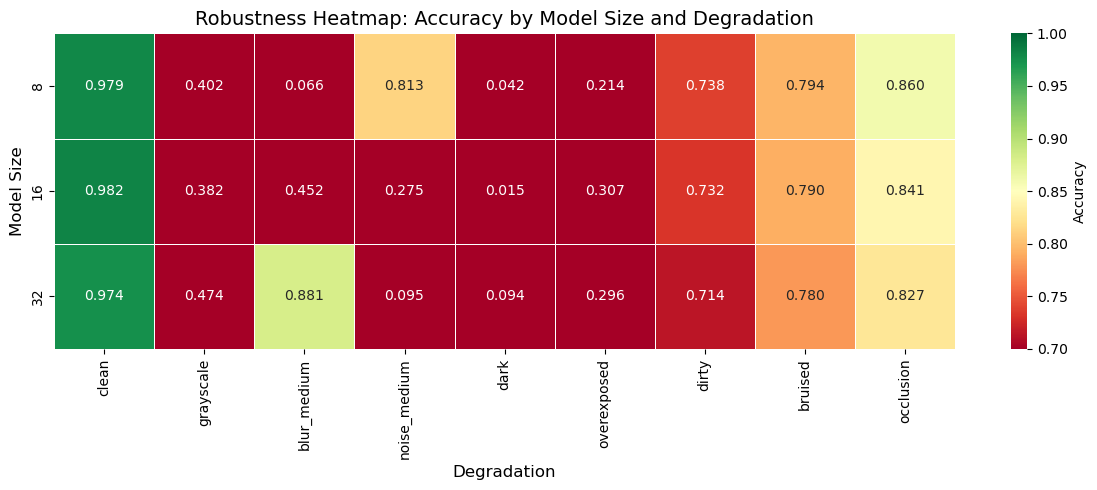

In [49]:
print("Generating heatmap: Accuracy matrix")

pivot_acc = results_global_df.pivot(index="model_size", columns="degradation", values="accuracy")

pivot_acc = pivot_acc[degradation_order]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="RdYlGn", cbar_kws={"label": "Accuracy"}, 
            vmin=0.7, vmax=1.0, linewidths=0.5, ax=ax)

ax.set_title("Robustness Heatmap: Accuracy by Model Size and Degradation", fontsize=14)
ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Model Size", fontsize=12)

plt.tight_layout()
plt.show()

Generating accuracy drop plot (vs clean baseline)


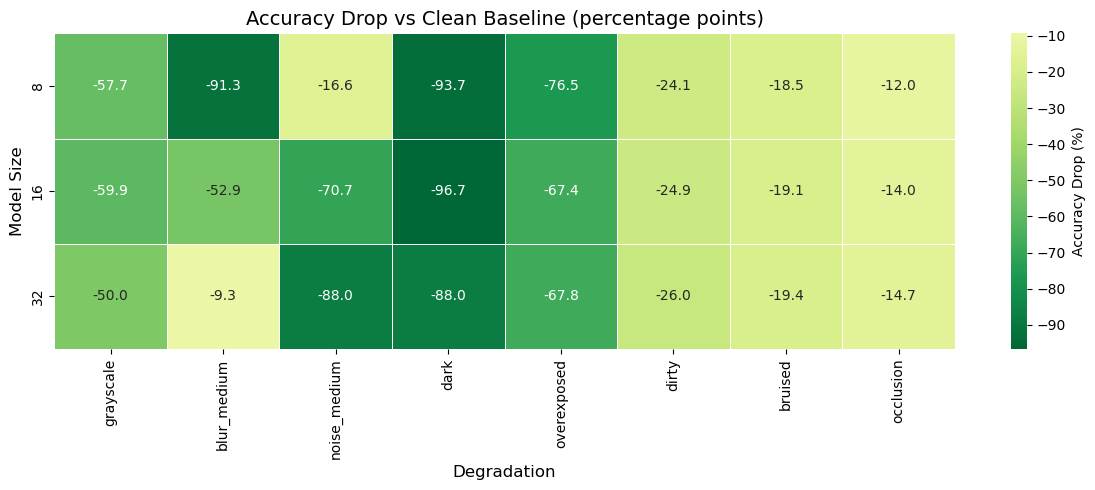

In [50]:
print("Generating accuracy drop plot (vs clean baseline)")

clean_acc = results_global_df[results_global_df["degradation"] == "clean"].set_index("model_name")["accuracy"]

drop_data = []
for _, row in results_global_df.iterrows():
    if row["degradation"] != "clean":
        drop = row["accuracy"] - clean_acc[row["model_name"]]
        drop_data.append({
            "model_name": row["model_name"],
            "model_size": row["model_size"],
            "degradation": row["degradation"],
            "accuracy_drop": drop,
            "accuracy_drop_pct": drop * 100,
        })

drop_df = pd.DataFrame(drop_data)

pivot_drop = drop_df.pivot(index="model_size", columns="degradation", values="accuracy_drop_pct")
pivot_drop = pivot_drop[[d for d in degradation_order if d != "clean"]]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_drop, annot=True, fmt=".1f", cmap="RdYlGn_r", center=0, 
            cbar_kws={"label": "Accuracy Drop (%)"}, linewidths=0.5, ax=ax)

ax.set_title("Accuracy Drop vs Clean Baseline (percentage points)", fontsize=14)
ax.set_xlabel("Degradation", fontsize=12)
ax.set_ylabel("Model Size", fontsize=12)

plt.tight_layout()
plt.show()

In [51]:
print("="*60)
print("SUMMARY TABLE: Accuracy by Model and Degradation")
print("="*60)

summary = results_global_df.pivot(index="degradation", columns="model_name", values="accuracy")
summary = summary[["8x8", "16x16", "32x32"]]
summary = summary.reindex(degradation_order)

print(summary.to_string(float_format="%.4f"))

print("\n" + "="*60)
print("Mean accuracy across degradations (excluding clean):")
print("="*60)

mean_no_clean = results_global_df[results_global_df["degradation"] != "clean"].groupby("model_name")["accuracy"].mean()
print(mean_no_clean.sort_values(ascending=False).to_string(float_format="%.4f"))

SUMMARY TABLE: Accuracy by Model and Degradation
model_name      8x8  16x16  32x32
degradation                      
clean        0.9794 0.9815 0.9742
grayscale    0.4022 0.3821 0.4744
blur_medium  0.0663 0.4525 0.8810
noise_medium 0.8129 0.2746 0.0946
dark         0.0425 0.0148 0.0941
overexposed  0.2144 0.3073 0.2960
dirty        0.7383 0.7324 0.7139
bruised      0.7940 0.7903 0.7798
occlusion    0.8596 0.8413 0.8273

Mean accuracy across degradations (excluding clean):
model_name
32x32   0.5202
8x8     0.4913
16x16   0.4744
